In [1]:
import torch
import torch.nn as nn
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt

from base_nonlinear import SelfAttn, W_svm_solver
from base import W_svm_solver as W_svm_solver_single


In [2]:
# if cross_attn is True, then we use cross attention
# if cross_attn is False, then we use self attention (i.e. set z_i = x_{i,atten_idx})
cross_attn = True
attn_idx = 0
lr = 0.1
mode = 'relu'

THRED_L = 1e-6
THRED_H = 1e-3

n = 3
T = 4
ds = [4,6,8,10]

ITN = 2001
RUN = 500
feq = 100
eps = torch.finfo(torch.double).eps

univariate = True

W_corrs = np.zeros((len(ds), RUN, ITN//feq+1))
W_corrs_svmeq = np.zeros((len(ds), RUN, ITN//feq+1))
W_corrs_single = np.zeros((len(ds), RUN, ITN//feq+1))

sfx_probs_zero_max = np.zeros((len(ds), RUN))

def data_generator(seed, mode='relu'):
    generator = torch.Generator()
    generator.manual_seed(seed)
    if mode == 'relu':
        v = torch.ones(d)
        v /= v.norm()
        V = torch.randn((d,d), generator=generator)
        V /= torch.norm(V)
        X = torch.randn((n, T, d), generator=generator)
        X /= torch.norm(X, dim=-1, keepdim=True)
        Y = 2 * torch.ones(n) * (torch.randn(n, generator=generator)>0) - 1
        Z = torch.randn((n, d), generator=generator)
        Z /= torch.norm(Z, dim=-1, keepdim=True)
        act_func = nn.ReLU()
        best_ids = (act_func(X @ V).sum(-1) * Y.view(-1,1)).argmax(dim=-1)
        return X, Y, Z, V, best_ids
    elif mode == 'lambda':
        v = torch.randn((d), generator=generator)
        v /= torch.norm(v)
        rand = torch.randn((n,T,d), generator=generator)
        X,_,_ = torch.svd(rand)
        Y = torch.ones(n) 
        Z = torch.randn((n, d), generator=generator)
        Z /= torch.norm(Z, dim=-1, keepdim=True)
        best_ids = ((X @ v) * Y.view(-1,1)).argmax(dim=-1)
        return X, Y, Z, v, best_ids
    else:
        raise ValueError('mode must be relu or lambda')

In [3]:
for di in range(len(ds)):
    d = ds[di]
    run = 0
    seed = 0
    while run < RUN:
        seed += 1
        X, Y, Z, v, best_ids = data_generator(seed, mode=mode)
        X, Y, Z, v = X.double(), Y.double(), Z.double(), v.double()
        if (Y == -1).sum() == 0:
            continue
        model = SelfAttn(d, univariate=univariate, mode=mode).double()
        if mode == 'relu':
            model.value.weight.data = v.T
            model.v.data = torch.ones(d).double()
        else:
            model.v.data = v
        if univariate:
            model.value.weight.data = v.T
            model.v.data = torch.ones(d).double()
            params = [model.W.weight]
        else:
            params = [model.query.weight, model.key.weight]
        optimizer = torch.optim.SGD(params, lr=lr)
        Ws = np.zeros((ITN//feq+1, d, d))
        for it in range(ITN):
            optimizer.zero_grad()
            out = model(X, cross_input=Z, attn_idx=attn_idx, cross_attn=cross_attn).view(-1)
            loss = torch.log(1+torch.exp(-Y*out))
            loss = loss.mean()
            if univariate is False:
                loss += eps * (model.key.weight.norm()**2 + model.query.weight.norm()**2)
            loss.backward()
            if univariate:
                model.W.weight.grad /= (model.W.weight.grad.norm()+eps)
            else:
                model.key.weight.grad /= ((model.key.weight.grad.norm())+eps)
                model.query.weight.grad /= ((model.query.weight.grad.norm())+eps)
            optimizer.step()

            if it % feq == 0:
                iti = it//feq
                W = model.W.weight.detach().T if univariate else model.query.weight.T.mm(model.key.weight).T.detach()
                W = W.numpy()
                Ws[iti] = W

        ## check the softmax output
        sfx_out = model.sfx_out.detach()
        if ((model.sfx_out.detach() > THRED_L) * (model.sfx_out.detach() <= THRED_H)).sum() > 0:
            # print(f'd{d}run{run}seed{seed}: failed (exist within [{THRED_L}, {THRED_H}])')
            continue
        if (model.sfx_out.detach() <= THRED_L).sum() == 0:
            # print(f'd{d}run{run}seed{seed}: failed (finite solution)')
            continue

        ## check the feasibility of SVMs
        relevant_ids = model.sfx_out.detach() > THRED_H
        opt_ids = model.sfx_out.detach().max(dim=-1)[1]
        try:
            sol, sol_svmeq = W_svm_solver(X, sfx_out, W_grad=W, cross_input=Z, attn_idx=attn_idx, cross_attn=cross_attn, fro=univariate, THRED=THRED_H)
            sol_single = W_svm_solver_single(X, opt_ids, cross_input=Z, attn_idx=attn_idx, cross_attn=cross_attn, fro=univariate)
            sol /= npl.norm(sol)
            sol_svmeq /= npl.norm(sol_svmeq)
            sol_single /= npl.norm(sol_single)
        except:
            # print(f'd{d}run{run}seed{seed}: failed (no feasible svm solutions)')
            continue

        ## compute the correlation
        for iti in range(ITN//feq+1):
            W_norm = npl.norm(Ws[iti])
            W = Ws[iti]/W_norm

            W_corrs[di, run, iti] = sol.reshape(-1).dot(W.reshape(-1))
            W_corrs_svmeq[di, run, iti] = sol_svmeq.reshape(-1).dot(W.reshape(-1))
            W_corrs_single[di, run, iti] = sol_single.reshape(-1).dot(W.reshape(-1))

        sfx_probs_zero_max[di, run] = (model.sfx_out.detach() * (~relevant_ids)).max()
        
        # print(f'd{d}run{run}seed{seed}: corres={W_corrs[di, run, -1], W_corrs_svmeq[di, run, -1], W_corrs_single[di, run, -1]}, max zero sfx out={sfx_probs_zero_max[di, run]}')
        run += 1

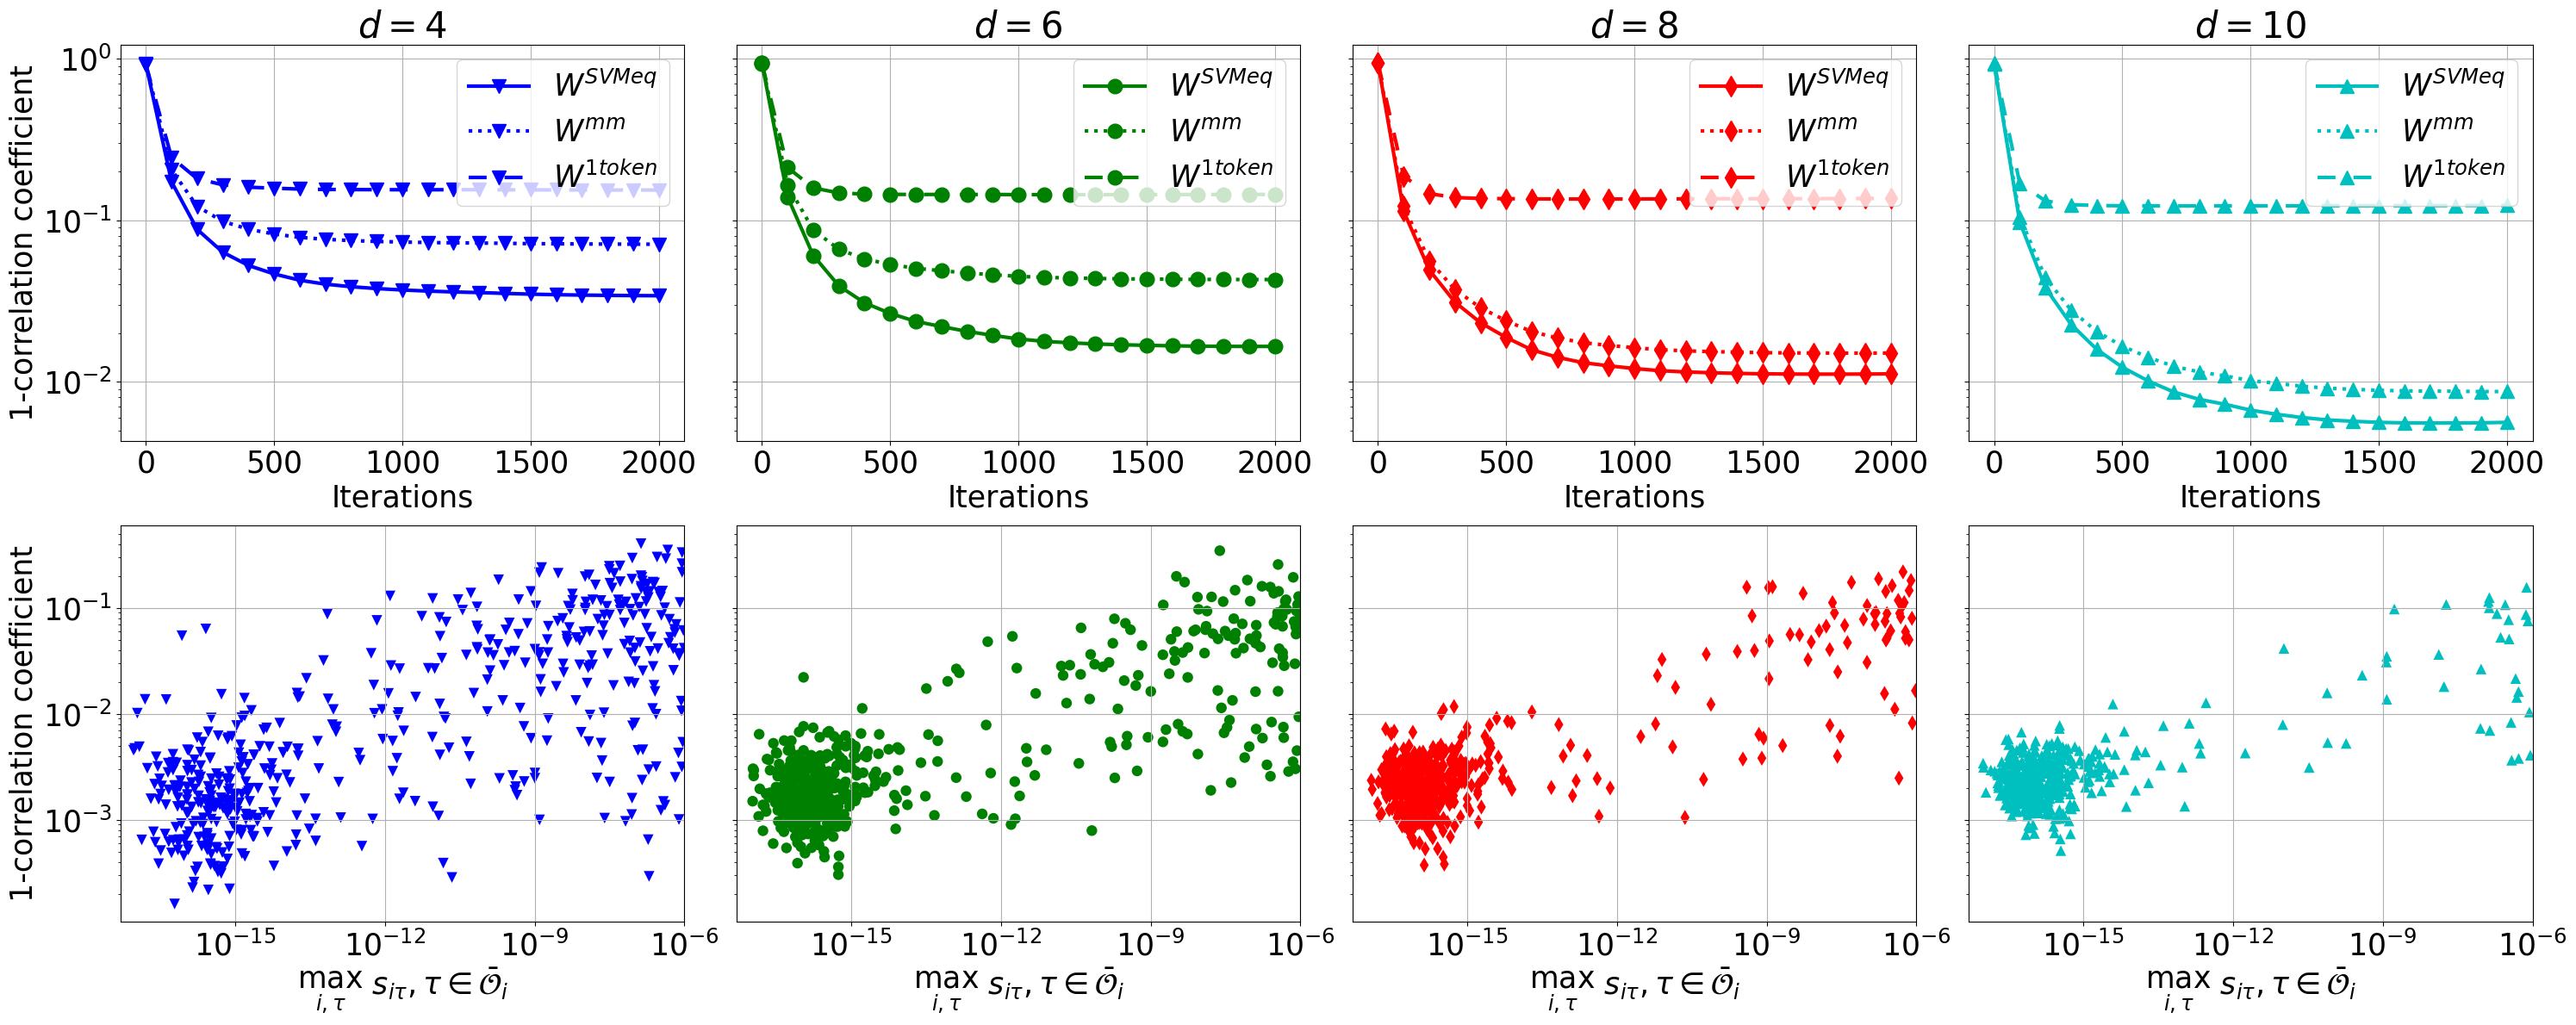

In [4]:
colors = ['b', 'g', 'r', 'c']
markers = ['v', 'o', 'd','^']

fig, axs = plt.subplots(2,4, sharey='row',figsize=(30,12))
for i in range(len(ds)):
    its = [j*feq for j in range(ITN//feq+1)]
    axs[0,i].plot(its,1-W_corrs_svmeq[i].mean(axis=0), color=colors[i], linestyle='-', linewidth=3, marker=markers[i], markersize=12, label=r'$W^{SVMeq}$')
    axs[0,i].plot(its,1-W_corrs[i].mean(axis=0), color=colors[i], linestyle=':', linewidth=3, marker=markers[i], markersize=12, label=r'$W^{mm}$')
    axs[0,i].plot(its,1-W_corrs_single[i].mean(axis=0), color=colors[i], linestyle=(0,(5,5)), linewidth=3, marker=markers[i], markersize=12, label=r'$W^{1token}$')
    axs[0,i].set_yscale('log')
    axs[0,i].set_xlabel(r'Iterations', fontsize=25)
    axs[0,i].set_xticks([0, 500, 1000, 1500, 2000])
    axs[0,i].xaxis.set_tick_params(labelsize=25)
    axs[0,i].grid()
    axs[0,i].set_title(rf'$d={ds[i]}$', fontsize=30)
    axs[0,i].legend(fontsize=25, loc=1)

    axs[1,i].scatter(sfx_probs_zero_max[i,:], 1-W_corrs_svmeq[i,:,-1], color=colors[i], linestyle='-', linewidth=3, marker=markers[i], label=rf'$d={ds[i]}$', alpha=1, edgecolors='none', s=80)
    axs[1,i].set_xscale('log')
    axs[1,i].set_yscale('log')
    axs[1,i].set_xlabel(r'$\max_{i,\tau}~s_{i\tau},\tau\in\bar\mathcal{O}_i$', fontsize=25)
    axs[1,i].set_xlim([0.5*1e-17,1e-6])
    axs[1,i].xaxis.set_tick_params(labelsize=25)
    axs[1,i].grid()

axs[0,0].set_yscale('log')
axs[0,0].set_ylabel(r'1-correlation coefficient', fontsize=25)
axs[0,0].yaxis.set_tick_params(labelsize=25)

axs[1,0].set_yscale('log')
axs[1,0].set_ylabel(r'1-correlation coefficient', fontsize=25)
axs[1,0].yaxis.set_tick_params(labelsize=25)

plt.tight_layout()
plt.show()